An introduction to the Gridded class. Loading variables and grid information.

This is designed to be a brief introduction to the Gridded class including:
    1. Creation of a Gridded object
    2. Loading data into the Gridded object.
    3. Combining Gridded output and Gridded domain data.
    4. Interrogating the Gridded object.
    5. Basic manipulation ans subsetting
    6. Looking at the data with matplotlib
    
    
### Loading and Interrogating

Begin by importing COAsT and define some file paths for NEMO output data and a NEMO domain, as an example of model data suitable for the Gridded object.

In [1]:
import coast
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Define some file paths
root = "../../"
dn_files = root + "./example_files/"

fn_nemo_dat = dn_files + "coast_example_nemo_data.nc"
fn_nemo_dom = dn_files + "coast_example_nemo_domain.nc"
fn_config_t_grid = root + "./config/example_nemo_grid_t.json"

We can create a new Gridded object by simple calling `coast.Gridded()`. By passing this a NEMO data file and a NEMO domain file, COAsT will combine the two into a single xarray dataset within the Gridded object. Each individual Gridded object should be for a specified NEMO grid type, which is specified in a configuration file which is also passed as an argument. The Dask library is switched on by default, chunking can be specified in the configuration file.

In [2]:
nemo_t = coast.Gridded(fn_data = fn_nemo_dat, fn_domain = fn_nemo_dom, config=fn_config_t_grid)

Our new Gridded object `nemo_t` contains a variable called dataset, which holds information on the two files we passed. Let’s have a look at this:

In [3]:
nemo_t.dataset

<xarray.Dataset>
Dimensions:              (t_dim: 7, z_dim: 51, axis_nbounds: 2, y_dim: 375,
                          x_dim: 297)
Coordinates:
  * time                 (t_dim) datetime64[ns] 2007-01-01T11:58:56 ... 2007-...
    longitude            (y_dim, x_dim) float32 ...
    latitude             (y_dim, x_dim) float32 ...
    depth_0              (z_dim, y_dim, x_dim) float32 0.5 0.5 0.5 ... 50.5 50.5
Dimensions without coordinates: t_dim, z_dim, axis_nbounds, y_dim, x_dim
Data variables:
    deptht_bounds        (z_dim, axis_nbounds) float32 dask.array<chunksize=(51, 2), meta=np.ndarray>
    ssh                  (t_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 375, 297), meta=np.ndarray>
    time_counter_bounds  (t_dim, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_instant         (t_dim) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    temperature          (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(2, 51, 375, 297), meta=np.ndarray>
    bathymetry           (y_dim, x_dim) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    e1                   (y_dim, x_dim) float32 ...
    e2                   (y_dim, x_dim) float32 ...
    e3_0                 (z_dim, y_dim, x_dim) float32 ...
    bottom_level         (y_dim, x_dim) float32 ...
Attributes:
    name:         AMM7_1d_20070101_20070131_25hourm_grid_T
    description:  ocean T grid variables, 25h meaned
    title:        ocean T grid variables, 25h meaned
    Conventions:  CF-1.6
    timeStamp:    2019-Dec-26 04:35:28 GMT
    uuid:         96cae459-d3a1-4f4f-b82b-9259179f95f7
    history:      Tue May 19 12:07:51 2020: ncks -v votemper,sossheig -d time...
    NCO:          4.4.7

This is an xarray dataset, which has all the information on netCDF style structures. You can see dimensions, coordinates and data variables. At the moment, none of the actual data is loaded to memory and will remain that way until it needs to be accessed.

Along with temperature (which has been renamed from votemper) a number of other things have happen under the hood:

1. The dimensions have been renamed to `t_dim`, `x_dim`, `y_dim`, `z_dim`
2. The coordinates have been renamed to `time`, `longitude`, `latitude` and `depth_0`. These are the coordinates for this grid (the t-grid). Also `depth_0` has been calculated as the 3D depth array at time zero.
3. The variables `e1`, `e2` and `e3_0` have been created. These are the metrics for the t-grid in the x-dim, y-dim and z_dim (at time zero) directions.

So we see that the Gridded class has standardised some variable names and created an object based on this discretisation grid by combining the appropriate grid information with all the variables on that grid.

We can interact with this as an xarray Dataset object. So to extract a specific variable (say temperature):

In [4]:
ssh = nemo_t.dataset.ssh
ssh

<xarray.DataArray 'ssh' (t_dim: 7, y_dim: 375, x_dim: 297)>
dask.array<open_dataset-df7d061f004f376ed413983d9fdba925sossheig, shape=(7, 375, 297), dtype=float32, chunksize=(2, 375, 297), chunktype=numpy.ndarray>
Coordinates:
  * time       (t_dim) datetime64[ns] 2007-01-01T11:58:56 ... 2007-01-31T11:5...
    longitude  (y_dim, x_dim) float32 ...
    latitude   (y_dim, x_dim) float32 ...
Dimensions without coordinates: t_dim, y_dim, x_dim
Attributes:
    units:               m
    online_operation:    instant
    interval_operation:  300 s
    interval_write:      1 d
    cell_methods:        time: point (interval: 300 s)

Or as a numpy array:

In [5]:
ssh_np = ssh.values
ssh_np.shape

(7, 375, 297)

Then lets plot up a single time snapshot of ssh using matplotlib:

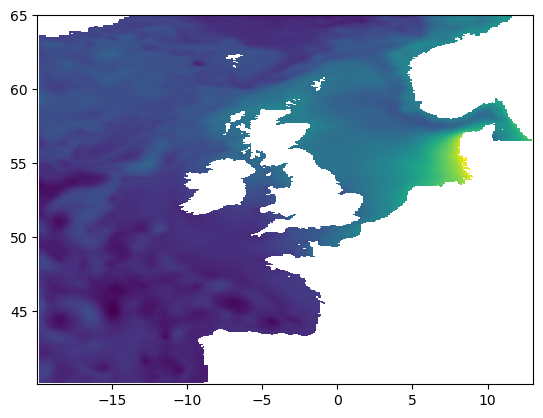

In [6]:
plt.pcolormesh(nemo_t.dataset.longitude, nemo_t.dataset.latitude, nemo_t.dataset.ssh[0])

### Some Manipulation

There are currently some basic subsetting routines for Gridded objects, to cut out specified regions of data. Fundamentally, this can be done using xarray’s isel or sel routines to index the data. In this case, the Gridded object will pass arguments straight through to `xarray.isel`.

Lets get the indices of all model points within 111km km of (5W, 55N):

In [7]:
ind_y, ind_x = nemo_t.subset_indices_by_distance(centre_lon=-5, centre_lat=55, radius=111)
ind_x.shape

(731,)

Now create a new, smaller subsetted Gridded object by passing those indices to `isel`.

In [8]:
nemo_t_subset = nemo_t.isel(x_dim=ind_x, y_dim=ind_y)
nemo_t_subset.dataset

<xarray.Dataset>
Dimensions:              (t_dim: 7, z_dim: 51, axis_nbounds: 2, dim_0: 731)
Coordinates:
  * time                 (t_dim) datetime64[ns] 2007-01-01T11:58:56 ... 2007-...
    longitude            (dim_0) float32 -5.556 -5.444 -5.333 ... -4.556 -4.444
    latitude             (dim_0) float32 54.07 54.07 54.07 ... 55.93 55.93 55.93
    depth_0              (z_dim, dim_0) float32 0.5024 0.5024 ... 10.11 10.11
Dimensions without coordinates: t_dim, z_dim, axis_nbounds, dim_0
Data variables:
    deptht_bounds        (z_dim, axis_nbounds) float32 dask.array<chunksize=(51, 2), meta=np.ndarray>
    ssh                  (t_dim, dim_0) float32 dask.array<chunksize=(2, 731), meta=np.ndarray>
    time_counter_bounds  (t_dim, axis_nbounds) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    time_instant         (t_dim) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    temperature          (t_dim, z_dim, dim_0) float32 dask.array<chunksize=(2, 51, 731), meta=np.ndarray>
    bathymetry           (dim_0) float32 71.06 92.49 106.8 101.8 ... 0.0 0.0 0.0
    e1                   (dim_0) float32 ...
    e2                   (dim_0) float32 ...
    e3_0                 (z_dim, dim_0) float32 ...
    bottom_level         (dim_0) float32 ...
Attributes:
    name:         AMM7_1d_20070101_20070131_25hourm_grid_T
    description:  ocean T grid variables, 25h meaned
    title:        ocean T grid variables, 25h meaned
    Conventions:  CF-1.6
    timeStamp:    2019-Dec-26 04:35:28 GMT
    uuid:         96cae459-d3a1-4f4f-b82b-9259179f95f7
    history:      Tue May 19 12:07:51 2020: ncks -v votemper,sossheig -d time...
    NCO:          4.4.7

Alternatively, xarray.isel can be applied directly to the `xarray.Dataset` object.
A longitude/latitude box of data can also be extracted using `Gridded.subset_indices()`.

### Plotting example for NEMO-ERSEM biogechemical variables

Import COAsT, define some file paths for NEMO-ERSEM output data and a NEMO domain, and read/load your NEMO-ERSEM data into a gridded object, example:

In [11]:
import coast
import matplotlib.pyplot as plt

# Define some file paths
root = "../../"
dn_files = root + "./example_files/"

fn_bgc_dat = dn_files + "coast_example_SEAsia_BGC_1990.nc"
fn_bgc_dom = dn_files + "coast_example_domain_SEAsia.nc"
fn_config_bgc_grid = root + "./config/example_nemo_bgc.json"

nemo_bgc = coast.Gridded(fn_data = fn_bgc_dat, fn_domain = fn_bgc_dom, config=fn_config_bgc_grid)
nemo_bgc.dataset

<xarray.Dataset>
Dimensions:       (t_dim: 3, z_dim: 75, y_dim: 554, x_dim: 684)
Coordinates:
  * time          (t_dim) datetime64[ns] 1990-01-16T12:00:00 ... 1990-03-16T1...
    longitude     (y_dim, x_dim) float64 ...
    latitude      (y_dim, x_dim) float64 ...
    depth_0       (z_dim, y_dim, x_dim) float64 0.5 0.502 0.5 ... 74.5 74.79
Dimensions without coordinates: t_dim, z_dim, y_dim, x_dim
Data variables:
    oxygen        (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(3, 75, 554, 684), meta=np.ndarray>
    dic           (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(3, 75, 554, 684), meta=np.ndarray>
    e3t           (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(3, 75, 554, 684), meta=np.ndarray>
    bathymetry    (y_dim, x_dim) float32 4.944e+03 4.656e+03 ... 4.544e+03
    e1            (y_dim, x_dim) float64 ...
    e2            (y_dim, x_dim) float64 ...
    e3_0          (z_dim, y_dim, x_dim) float64 ...
    bottom_level  (y_dim, x_dim) int32 ...
Attributes:
    name:         SEAsia_HAD_1m_19900101_19901231_ptrc_T
    description:  tracer variables
    title:        tracer variables
    Conventions:  CF-1.6
    timeStamp:    2020-Oct-07 10:11:58 GMT
    uuid:         701bb916-558d-4ee8-9cf6-89454c7bc99f
    history:      Thu Mar 24 10:45:55 2022: ncks -d time_counter,0,2,1 coast_...
    NCO:          netCDF Operators version 4.7.5 (Homepage = http://nco.sf.ne...

As an example plot a snapshot of dissolved inorganic carbon at the sea surface

/var/folders/m8/d31wn5y90935821nhqkkwtq80000gr/T/ipykernel_35977/3227893638.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(


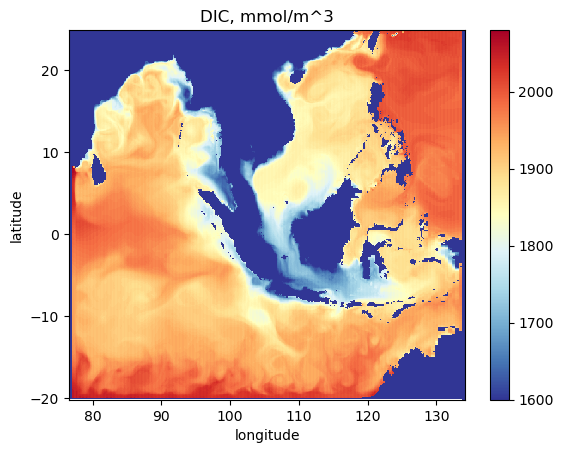

In [12]:
fig = plt.figure()
plt.pcolormesh(
    nemo_bgc.dataset.longitude,
    nemo_bgc.dataset.latitude,
    nemo_bgc.dataset.dic.isel(t_dim=0).isel(z_dim=0),
    cmap="RdYlBu_r",
    vmin=1600,
    vmax=2080,
)
plt.colorbar()
plt.title("DIC, mmol/m^3")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()